In [400]:
import numpy as np
import matplotlib as plt
from matplotlib.image import imread
import matplotlib.pyplot as p
from scipy.signal import convolve2d
from scipy.signal import fftconvolve
from numpy.random import random
from os import listdir
from time import time
%matplotlib inline

# TODO
- [ ] Lave dense layers
- [ ] Lave conv layers
- [ ] Lave max-pooling
- [ ] Lave en test model (med test data)
- [ ] Evaluate 🎉
- [ ] Lav den rigtige model
- [ ] webcam blib blob

In [401]:
a = random((200,200))
b = random((10,10))

aa = time()
convolve2d(a,b)
ba = time()
ab = time()
fftconvolve(a,b)
bb = time()

print("normal convolution time: ", (ba-aa)*1000)
print("fft convolution time:    ", (bb-ab)*1000)

normal convolution time:  41.608333587646484
fft convolution time:     3.6118030548095703


In [402]:
image_src = imread("H_test.jpg")

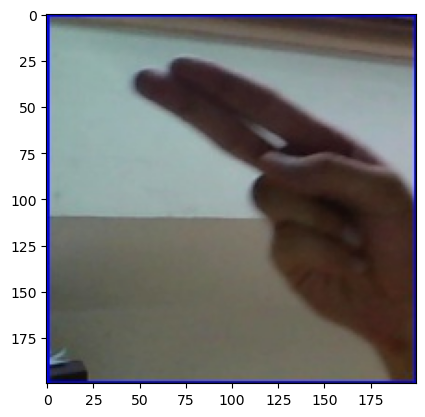

In [403]:
p.imshow(image_src)

In [404]:
image = [n / 255. for n in image_src[:,:,0]]

# Define the Sobel filter kernels (constant kernels for edge detection)
kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Perform convolution with the kernels to get the horizontal and vertical edges
edges_x = convolve2d(image, kernel_x, mode='valid')
edges_y = convolve2d(image, kernel_y, mode='valid')

# Combine the horizontal and vertical edges to get the final edge image
edges = np.sqrt(np.square(edges_x) + np.square(edges_y))

# Normalize the edge image to a range between 0 and 1
edges = edges / np.max(edges)

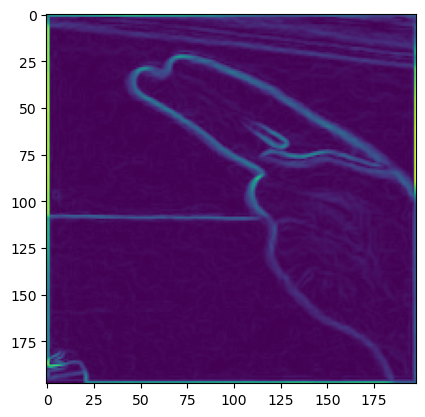

In [405]:
p.imshow(edges,)

In [406]:
def rvec(v): # Returns a vector as a single row matrix
    return v.reshape(1, len(v))

def cvec(v): # Returns a vector as a single column matrix
    return v.reshape(len(v), 1)


class DenseLayer:
    def __init__(self, i, o):
        self.w = random((o, i))
        self.b = random(o)

    def predict(self, i):
        return np.matmul(self.w, i.flatten()) + self.b

    def backprop(self, i, dy):
        i = i.flatten()
        self.w -= np.matmul(cvec(dy), rvec(i))
        self.b -= dy
        return np.matmul(self.w.T, dy)

In [407]:
# input -> l1 (CNN) -> l2 (CNN) -> l3 -> cost
# target -> Δcost -> Δl3 -> Δl2 -> Δl1

# x = input matrix
# w = cnn filter
# Δy = gradient

class CNN:
    def __init__(self, filter_shape):
        self.filter = random(filter_shape)

    def predict(self, i):
        return fftconvolve(i, self.filter, mode='same')
        # mode='same'

    def backprop(self, x, Δy):
        Δw = np.zeros(self.filter.shape)

        for w_row in range(0,self.filter.shape[0]):
            for w_col in range(0,self.filter.shape[1]):
                for x_row in range(0,x.shape[0]):
                    for x_col in range(0,x.shape[1]):
                        Δw[w_row, w_col] += Δy[min(x_row + w_row, Δy.shape[0]-1), max(x_col + w_col, Δy.shape[1]-1)] * x[x_row, x_col]

        self.filter -= Δw
        return fftconvolve(Δy, self.filter, mode='same')

#def Δ_convolve(w, x, Δy):
#    Δw = convolve2d(w, Δy, mode='valid')
#    Δw = np.zeros_like(w)
#    
#    for i in range(w.shape[0]):
#        for j in range(w.shape[1]):
#            Δw[i,j] = np.sum(Δy[i:i+x.shape[0], j:j+x.shape[1]] * x)

#    w -= Δw
#    return Δw


In [408]:
class MaxPool:
    def __init__(self, shape, scale):
        self.shape = shape
        self.scale = scale

    def predict(self, i):
        r = int(self.shape[0]/self.scale)
        c = int(self.shape[1]/self.scale)
        s = self.scale
        o = np.zeros((r, c))

        for row in range(0, r):
            for col in range(0, c):
                i_ = i[r*s:r*s+r, c*s:c*s+c]
                if i_.shape == (0,0):
                    continue
                o[row,col] = i_.max()
        return o
    
    def backprop(self, dy):
        r = int(self.shape[0]/self.scale)
        c = int(self.shape[1]/self.scale)
        dy = dy.reshape((r,c))
        o = np.zeros(self.shape)

        for row in range(0,self.shape[0]):
            for col in range(0,self.shape[1]):
                o[row, col] = dy[int(row/self.scale), int(col/self.scale)]

        return o

In [409]:
l1 = DenseLayer(2,3)
o = l1.predict(random(2))
target = random(3)

#for n in range(0,100):

In [410]:
train_path = "asl_alphabet_train/asl_alphabet_train/"
test_path = "asl_alphabet_test/asl_alphabet_test/"

# Load training data from `train_path`
train_data = {}
for letter in listdir(train_path):
    path = train_path+letter+"/"
    train_data[letter] = [path+f for f in listdir(path)]

In [411]:
train_data.keys()

dict_keys(['G', 'U', 'R', 'J', 'K', 'W', 'H', 'M', 'space', 'B', 'Z', 'E', 'O', 'I', 'nothing', 'Q', 'F', 'V', 'P', 'Y', 'T', 'N', 'del', 'L', 'D', 'C', 'A', 'X', 'S'])

In [412]:
labels = {}
i = 0
for n in train_data.keys():
    labels[n]=i
    i+=1

In [413]:
def onehot(n, len):
    o = np.zeros(len)
    o[n] = 1
    return 0

In [414]:
l1 = CNN((10, 10))
l2 = MaxPool((200, 200), 10)
#l3 = CNN((20,20))
#l4 = MaxPool(())
l3 = DenseLayer(20*20, len(labels))

i = 0
correct = 0

for n in range(0,100):
    for letter in train_data.keys():
        img = imread(train_data[letter][n])
        img = np.array([n / 255. for n in img[:,:,0]])

        target = onehot(labels[letter], len(labels))

        l1o = l1.predict(img)
        l2o = l2.predict(l1o)
        out = l3.predict(l2o.flatten())

        if labels[letter] == out.argmax():
            correct += 1
        
        dc = 2*(out - target)
        d3 = l3.backprop(l2o, dc)
        d2 = l2.backprop(d3)
        l1.backprop(img, d2)

        i += 1
    print("accuracy: ", correct/i, "%")

IndexError: index 200 is out of bounds for axis 1 with size 200

In [ ]:
np.matmul(rvec(np.array([1,2,3])), cvec(np.array([10,100])))

array([[ 10, 100],
       [ 20, 200],
       [ 30, 300]])